In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import requests
from IPython.display import HTML
import geopandas as gpd
from fiona.crs import from_epsg
from shapely.geometry import Point
import os
import seaborn
%pylab inline

import statsmodels.formula.api as smf

import seaborn as sns
sns.set_style('whitegrid')

PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
/home/cusp/dcr346/PUIdata


In [2]:
import laspy
from laspy.file import File
import scipy
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata

In [3]:
data15 = File('2015 T_316000_233000 - 15m_v2.las', mode='r')
data15.read
points15 = np.array([data15.x, data15.y]).T
points15

array([[ 316285.01170923,  233454.48233112],
       [ 316285.11170923,  233455.15133112],
       [ 316285.37170923,  233456.89933112],
       ..., 
       [ 316283.54870923,  233452.72433112],
       [ 316283.57770923,  233452.87133112],
       [ 316283.58770923,  233452.26033112]])

## Defining the grid

In [19]:
grid_x, grid_y = np.mgrid[data15.x.min() : data15.x.max() : 0.01, data15.y.min() : data15.y.max() : 0.01]

In [20]:
grid_y

array([[ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       ..., 
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112],
       [ 233445.67033112,  233445.68033112,  233445.69033112, ...,
         233460.64033112,  233460.65033112,  233460.66033112]])

## Creat a grid of Z (height) values

In [21]:
grid_z15 = griddata(points15, data15.z, (grid_x, grid_y), method = 'nearest')

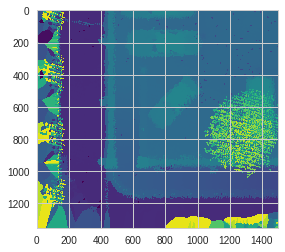

In [22]:
plt.imshow(grid_z15, cmap='viridis')
plt.show()

In [23]:
data07 = File('2007 316000_233500 - 15m_v2.las', mode='r')
data07.read
points07 = np.array([data07.x, data07.y]).T
points07

array([[ 316285.27435828,  233460.60167551],
       [ 316285.25835828,  233460.56667551],
       [ 316285.28035828,  233460.52467551],
       ..., 
       [ 316272.11735828,  233458.02467551],
       [ 316272.03035828,  233457.51267551],
       [ 316271.94135828,  233457.00867551]])

In [24]:
grid_z07 = griddata(points07, data07.z, (grid_x, grid_y), method = 'nearest')

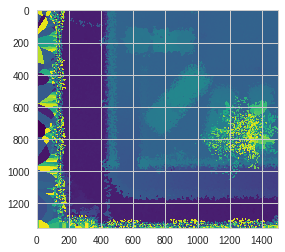

In [25]:
plt.imshow(grid_z07, cmap='viridis')
plt.show()

## Grid of change of Z values

In [39]:
change = np.abs(grid_z15 - grid_z07)
change

array([[  9.27356250e+00,   9.27356250e+00,   9.27356250e+00, ...,
          2.35625000e-02,   2.35625000e-02,   2.35625000e-02],
       [  9.27356250e+00,   9.27356250e+00,   9.27356250e+00, ...,
          2.35625000e-02,   2.35625000e-02,   2.35625000e-02],
       [  9.27356250e+00,   9.27356250e+00,   9.27356250e+00, ...,
          2.35625000e-02,   2.35625000e-02,   2.35625000e-02],
       ..., 
       [  2.60143750e+00,   2.60143750e+00,   2.60143750e+00, ...,
          5.62500000e-04,   5.62500000e-04,   5.62500000e-04],
       [  2.60143750e+00,   2.60143750e+00,   2.60143750e+00, ...,
          5.62500000e-04,   5.62500000e-04,   5.62500000e-04],
       [  2.60143750e+00,   2.60143750e+00,   2.60143750e+00, ...,
          5.62500000e-04,   5.62500000e-04,   5.62500000e-04]])

In [40]:
change.shape

(1352, 1500)

In [41]:
change.std()

2.2035707362848043

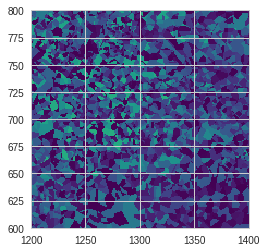

In [42]:
plt.imshow(change, cmap='viridis')
plt.ylim(600,800)
plt.xlim(1200,1400)
plt.show()